# 문제설명
## 음식배달 서비스(배민, 쿠팡이츠 등)를 위한 예측모델
- 이 모델이 예측하는 값 :  "음식배달에 걸리는 시간"
- 예측 배달시간보다 실제 배달시간이 더 걸린 경우(under-prediction)가 반대(over-prediction)보다 두 배로 사용자의 경험에 안 좋은 영향을 끼친다.
- 가능한 실제 배달시간과 가까운 값을 예측하되 동시에 under-prediction을 최소화하자.



# 학습/테스트 데이터
##  "delivery_raw.csv" 

> ### 시간 속성  
> - market_id: 지역(배달이 이루어지는 도시) 아이디
> - created_at: 주문이 생성된 시간의 Timestamp(UTC)
> - actual_delivery_time: 주문자가 배달을 받은 시간의 Timestamp(UTC)
> ### 식당 속성
> - store_id: 식당 아이디
> - store_primary_category: 식당의 카테고리(italian, asian 등)
> - order_protocol: 주문을 받을 수 있는 방식을 나타내는 아이디
> ### 주문 속성
> - total_items: 주문에 포함된 아이템(음식) 개수
> - subtotal: 가격(센트 단위)
> - num_distinct_items: 주문에 포함된 비중복 아이템 개수
> - min_item_price: 주문에 포함된 아이템 중 가장 싼 아이템의 가격
> - max_item_price: 주문에 포함된 아이템 중 가장 비싼 아이템의 가격
> ### 지역 상황 속성
> - total_onshift: 주문이 생성되었을 때 가게로부터 10마일 이내에 있는 배달원들의 수
> - total_busy: 위 배달원들 중 주문에 관여하고 있는 사람들의 수
> - total_outstanding_orders: 주문한 가게로부터 10마일 이내에 있는 다른 주문들의 수
> ### 다른 모델들의 예측값
> - estimated_order_place_duration: 식당이 주문을 받을 때까지 걸릴 것으로 예상되는 시간(초단위)
> - estimated_store_to_consumer_driving_duration: 식당에서 출발해 주문자에 도착할 때까지 걸릴 것으로 예측되는 시간(초단위)
   


위 속성들 중 actual_delivery_time을 제외한 모든 속성들을 모델의 입력으로 사용할 수 있습니다.  
모델이 예측해야하는 값은 actual_delivery_time과 created_at을 사용해서 생성하면 됩니다(초단위로 표현된 두 속성의 차이값).  



주어진 이 속성들 외에 이것들로부터 파생될 수 있는 속성들을 추가로 만들어서 사용할 수도 있습니다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
delivery_df = pd.read_csv('delivery_raw.csv',sep='\t')

delivery_df.head(20)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,5477,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,5477,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,446,638.0
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477,NaN,1.0,4,4850,4,750,1800,7.0,8.0,7.0,446,626.0
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0
9,3.0,2015-02-18 01:15:45,2015-02-18 02:08:57,5477,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,446,715.0


In [3]:
delivery_df.dtypes

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift                                   float64
total_busy                                      float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
dtype: object

In [4]:
delivery_df.count()

market_id                                       196441
created_at                                      197428
actual_delivery_time                            197421
store_id                                        197428
store_primary_category                          192668
order_protocol                                  196433
total_items                                     197428
subtotal                                        197428
num_distinct_items                              197428
min_item_price                                  197428
max_item_price                                  197428
total_onshift                                   181166
total_busy                                      181166
total_outstanding_orders                        181166
estimated_order_place_duration                  197428
estimated_store_to_consumer_driving_duration    196902
dtype: int64

In [5]:
delivery_df.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift                                   16262
total_busy                                      16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [6]:
# 실제 배달 시간을 알 수 없는 record drop
delivery_df.dropna(subset=['actual_delivery_time'],inplace=True)

delivery_df.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift                                   16262
total_busy                                      16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [7]:
delivery_df['created_at'] = pd.to_datetime(delivery_df['created_at'])
delivery_df['actual_delivery_time'] = pd.to_datetime(delivery_df['actual_delivery_time'])


In [8]:
# 배달 시간 column 추가

delivery_df['real_delivery_time'] = delivery_df['actual_delivery_time'] - delivery_df['created_at']


In [9]:
delivery_df['real_delivery_time'].head(5)

0   0 days 01:02:59
1   0 days 01:07:04
2   0 days 00:29:41
3   0 days 00:51:15
4   0 days 00:39:50
Name: real_delivery_time, dtype: timedelta64[ns]

In [10]:
# 단위 맞추기
delivery_df['real_delivery_time'] = delivery_df['real_delivery_time'].dt.total_seconds()

delivery_df['real_delivery_time'].head(5)

0    3779.0
1    4024.0
2    1781.0
3    3075.0
4    2390.0
Name: real_delivery_time, dtype: float64

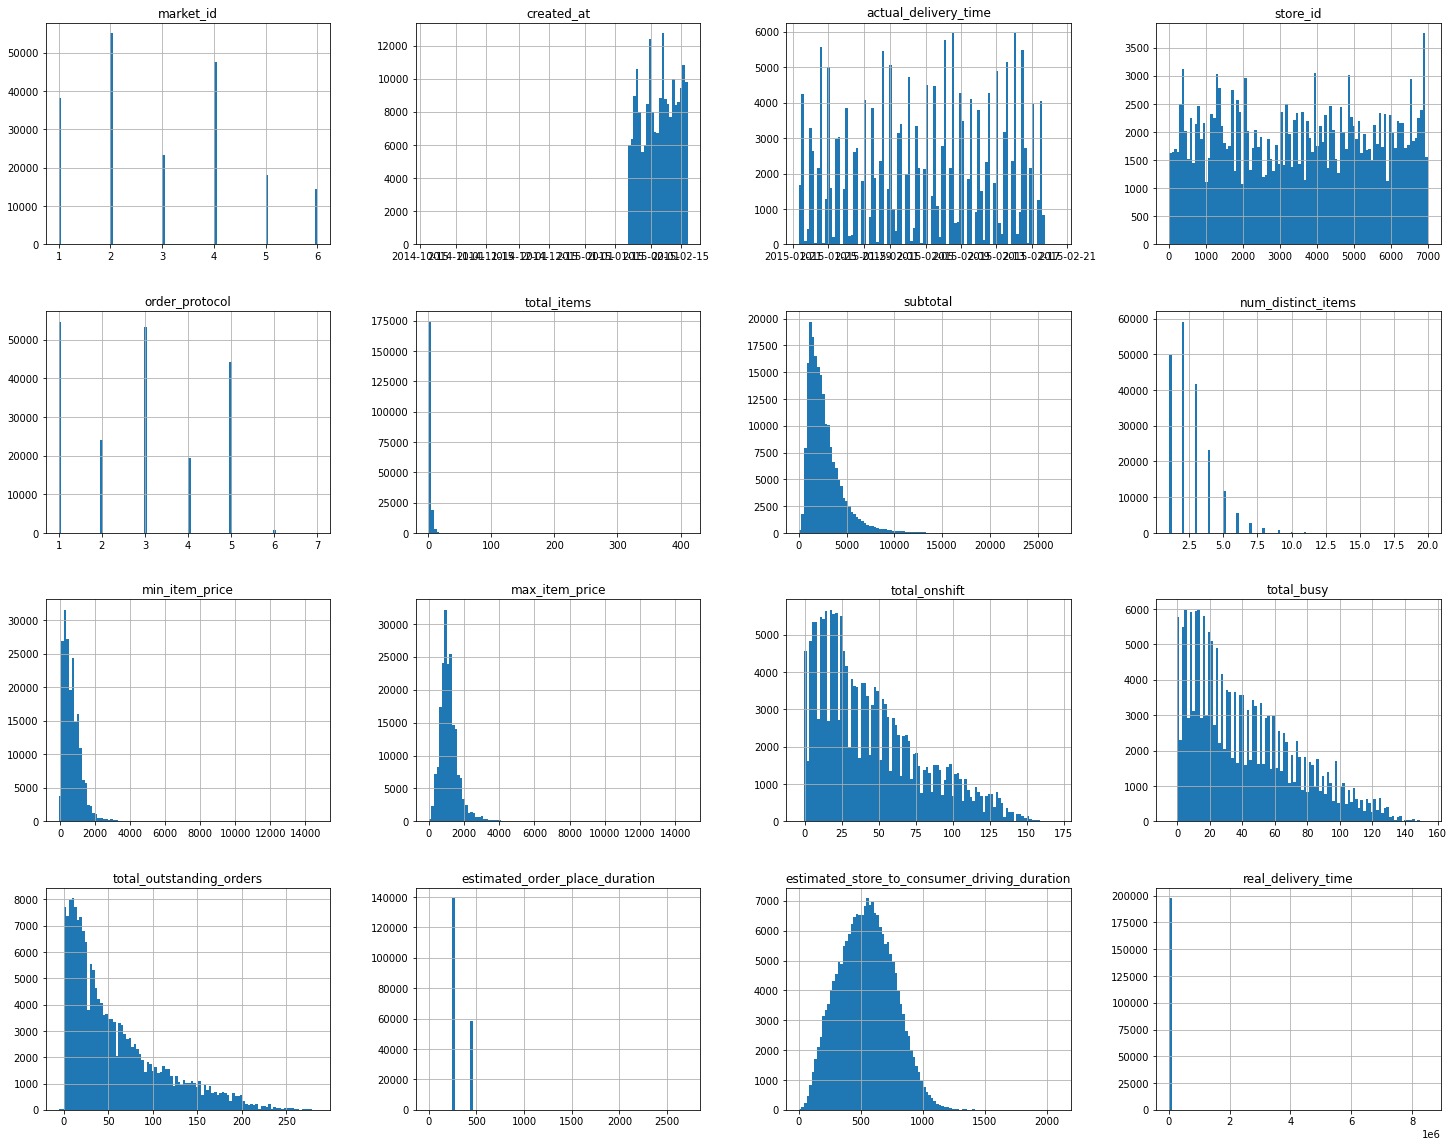

In [11]:
delivery_df.hist(bins = 100 ,figsize=(25,20))
plt.show()

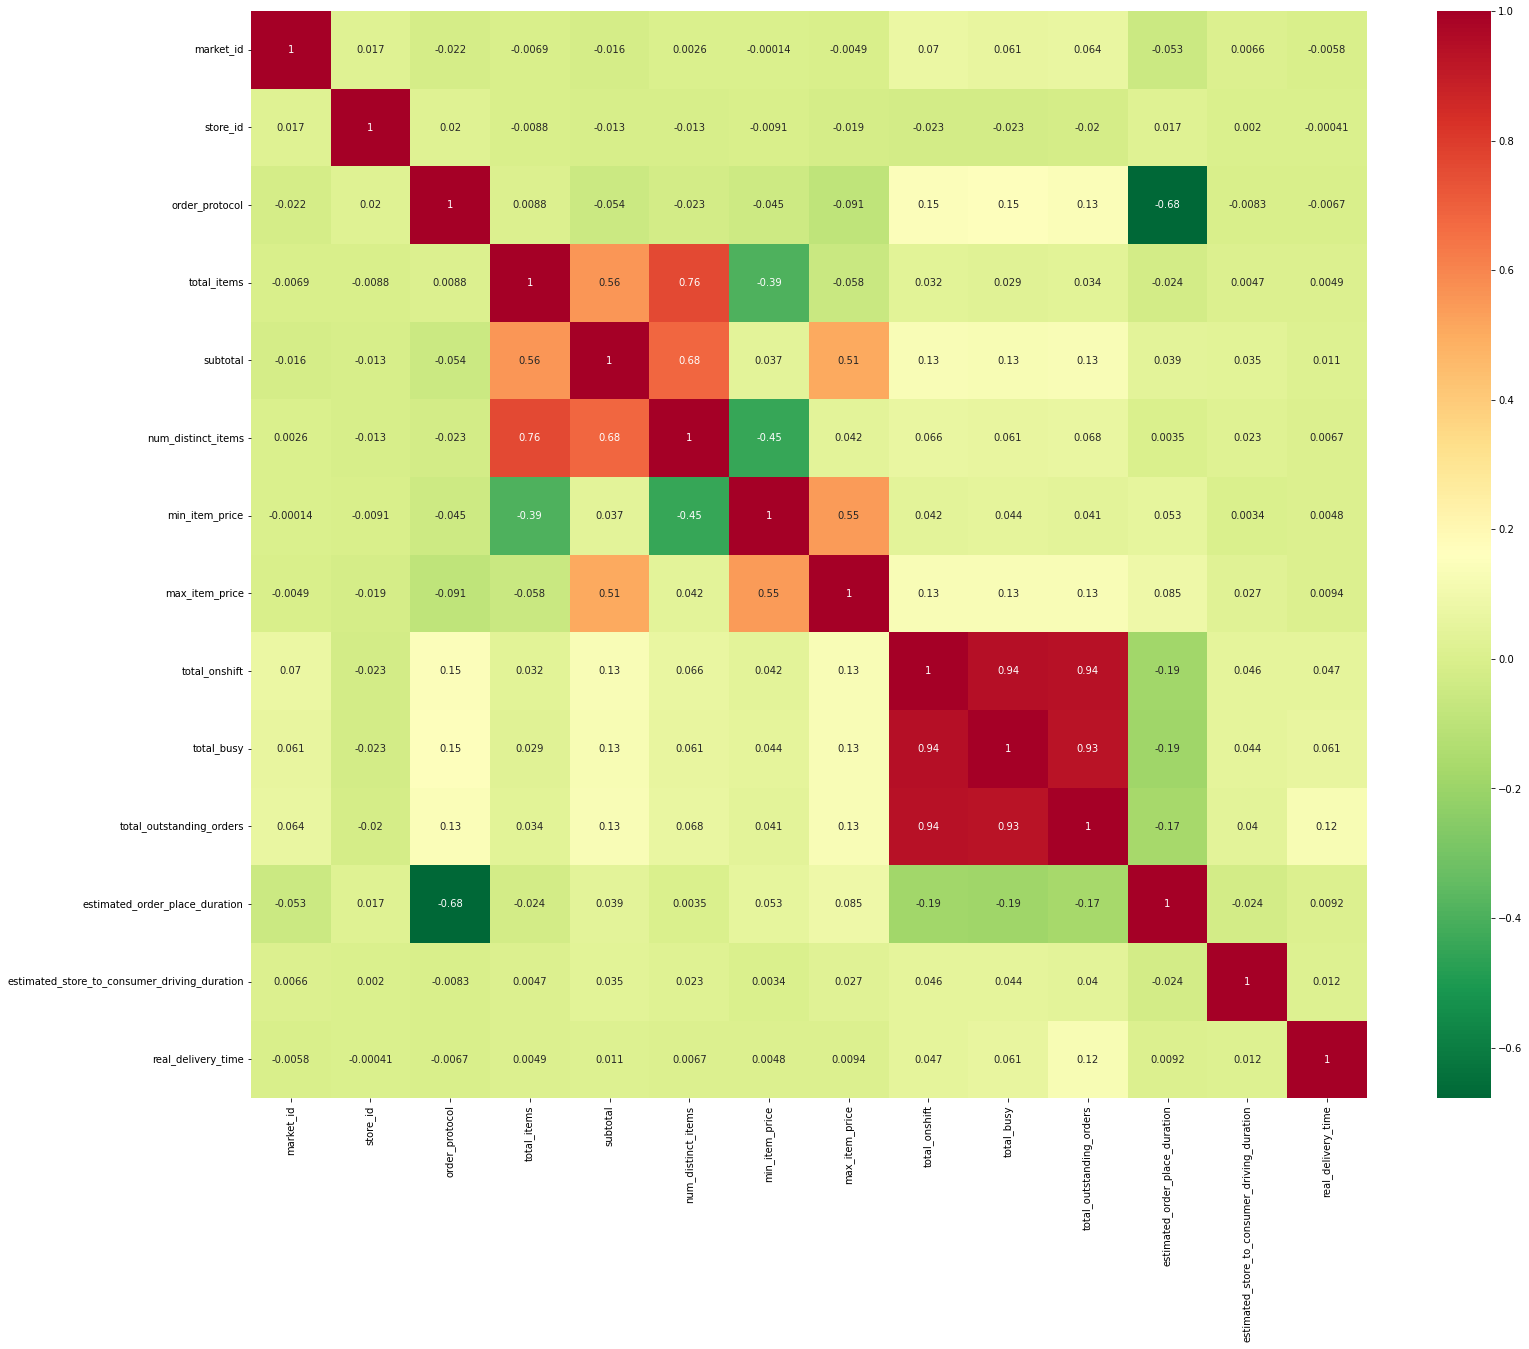

In [12]:
plt.figure(figsize=(25,20))
sns.heatmap(delivery_df.corr(), annot = True, cmap='RdYlGn_r')
plt.show()

In [13]:
delivery_df['market_id'].value_counts()

2.0    55055
4.0    47597
1.0    38037
3.0    23296
5.0    17999
6.0    14450
Name: market_id, dtype: int64

In [14]:
delivery_df['store_primary_category'].value_counts()

american             19399
pizza                17320
mexican              17098
burger               10958
sandwich             10059
                     ...  
lebanese                 9
belgian                  2
indonesian               2
chocolate                1
alcohol-plus-food        1
Name: store_primary_category, Length: 74, dtype: int64

In [15]:
delivery_df['store_primary_category'].fillna('other', inplace=True)
delivery_df['store_primary_category'].astype('str')

0         american
1          mexican
2            other
3            other
4            other
            ...   
197423        fast
197424        fast
197425        fast
197426    sandwich
197427    sandwich
Name: store_primary_category, Length: 197421, dtype: object

In [16]:
delivery_df['order_protocol'].value_counts()

1.0    54723
3.0    53197
5.0    44289
2.0    24051
4.0    19353
6.0      794
7.0       19
Name: order_protocol, dtype: int64

In [17]:
# 최빈값으로 fillna
most_freq = delivery_df['order_protocol'].value_counts().idxmax()
delivery_df['order_protocol'].fillna(most_freq, inplace=True)

In [18]:
delivery_df['total_onshift'].value_counts()

 0.0      3615
 18.0     2924
 15.0     2912
 21.0     2841
 19.0     2824
          ... 
 164.0       1
 159.0       1
 169.0       1
-4.0         1
 168.0       1
Name: total_onshift, Length: 172, dtype: int64

In [19]:
delivery_df[delivery_df['total_onshift']<0]['total_onshift'].count()

21

In [20]:
# 배달원의 수가 음수일 수는 없으므로 
delivery_df['total_onshift'][delivery_df['total_onshift']<0] = 0

C:\Users\User\AppData\Local\Temp/ipykernel_12048/2597266965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['total_onshift'][delivery_df['total_onshift']<0] = 0


In [21]:
delivery_df[delivery_df['total_busy']<0]['total_busy'].count()

21

In [22]:
delivery_df[delivery_df['total_outstanding_orders']<0]['total_outstanding_orders'].count()

44

In [23]:
# 마찬가지로 사람의 수가 음수일 수는 없으므로 0으로 처리
delivery_df['total_busy'][delivery_df['total_busy']<0] = 0
delivery_df['total_outstanding_orders'][delivery_df['total_outstanding_orders']<0] = 0

C:\Users\User\AppData\Local\Temp/ipykernel_12048/680098971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['total_busy'][delivery_df['total_busy']<0] = 0
C:\Users\User\AppData\Local\Temp/ipykernel_12048/680098971.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['total_outstanding_orders'][delivery_df['total_outstanding_orders']<0] = 0


In [24]:
delivery_df[['market_id','total_onshift']].groupby(['market_id']).median()

,total_onshift
market_id,
1.0,19.0
2.0,55.0
3.0,15.0
4.0,60.0
5.0,20.0
6.0,36.0


In [25]:
delivery_df['total_onshift'][(delivery_df['market_id'] == 1.0) & (delivery_df['total_onshift'].isna())] = 19.0
delivery_df['total_onshift'][(delivery_df['market_id'] == 2.0) & (delivery_df['total_onshift'].isna())] = 55.0
delivery_df['total_onshift'][(delivery_df['market_id'] == 3.0) & (delivery_df['total_onshift'].isna())] = 15.0
delivery_df['total_onshift'][(delivery_df['market_id'] == 4.0) & (delivery_df['total_onshift'].isna())] = 60.0
delivery_df['total_onshift'][(delivery_df['market_id'] == 5.0) & (delivery_df['total_onshift'].isna())] = 20.0
delivery_df['total_onshift'][(delivery_df['market_id'] == 6.0) & (delivery_df['total_onshift'].isna())] = 36.0

C:\Users\User\AppData\Local\Temp/ipykernel_12048/1623100256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['total_onshift'][(delivery_df['market_id'] == 1.0) & (delivery_df['total_onshift'].isna())] = 19.0
C:\Users\User\AppData\Local\Temp/ipykernel_12048/1623100256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['total_onshift'][(delivery_df['market_id'] == 2.0) & (delivery_df['total_onshift'].isna())] = 55.0
C:\Users\User\AppData\Local\Temp/ipykernel_12048/1623100256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

In [26]:
delivery_df[['market_id','total_busy']].groupby(['market_id']).median()

,total_busy
market_id,
1.0,18.0
2.0,53.0
3.0,13.0
4.0,57.0
5.0,16.0
6.0,35.0


In [27]:
delivery_df['total_busy'][(delivery_df['market_id'] == 1.0) & (delivery_df['total_busy'].isna())] = 18.0
delivery_df['total_busy'][(delivery_df['market_id'] == 2.0) & (delivery_df['total_busy'].isna())] = 53.0
delivery_df['total_busy'][(delivery_df['market_id'] == 3.0) & (delivery_df['total_busy'].isna())] = 13.0
delivery_df['total_busy'][(delivery_df['market_id'] == 4.0) & (delivery_df['total_busy'].isna())] = 57.0
delivery_df['total_busy'][(delivery_df['market_id'] == 5.0) & (delivery_df['total_busy'].isna())] = 16.0
delivery_df['total_busy'][(delivery_df['market_id'] == 6.0) & (delivery_df['total_busy'].isna())] = 35.0

C:\Users\User\AppData\Local\Temp/ipykernel_12048/296702648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['total_busy'][(delivery_df['market_id'] == 1.0) & (delivery_df['total_busy'].isna())] = 18.0
C:\Users\User\AppData\Local\Temp/ipykernel_12048/296702648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['total_busy'][(delivery_df['market_id'] == 2.0) & (delivery_df['total_busy'].isna())] = 53.0
C:\Users\User\AppData\Local\Temp/ipykernel_12048/296702648.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

In [28]:
delivery_df[['market_id','total_outstanding_orders']].groupby(['market_id']).median()

,total_outstanding_orders
market_id,
1.0,22.0
2.0,69.0
3.0,14.0
4.0,74.0
5.0,20.0
6.0,43.0


In [29]:
delivery_df['total_outstanding_orders'][(delivery_df['market_id'] == 1.0) & (delivery_df['total_outstanding_orders'].isna())] = 22.0
delivery_df['total_outstanding_orders'][(delivery_df['market_id'] == 2.0) & (delivery_df['total_outstanding_orders'].isna())] = 69.0
delivery_df['total_outstanding_orders'][(delivery_df['market_id'] == 3.0) & (delivery_df['total_outstanding_orders'].isna())] = 14.0
delivery_df['total_outstanding_orders'][(delivery_df['market_id'] == 4.0) & (delivery_df['total_outstanding_orders'].isna())] = 74.0
delivery_df['total_outstanding_orders'][(delivery_df['market_id'] == 5.0) & (delivery_df['total_outstanding_orders'].isna())] = 20.0
delivery_df['total_outstanding_orders'][(delivery_df['market_id'] == 6.0) & (delivery_df['total_outstanding_orders'].isna())] = 43.0

C:\Users\User\AppData\Local\Temp/ipykernel_12048/3706515447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['total_outstanding_orders'][(delivery_df['market_id'] == 1.0) & (delivery_df['total_outstanding_orders'].isna())] = 22.0
C:\Users\User\AppData\Local\Temp/ipykernel_12048/3706515447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['total_outstanding_orders'][(delivery_df['market_id'] == 2.0) & (delivery_df['total_outstanding_orders'].isna())] = 69.0
C:\Users\User\AppData\Local\Temp/ipykernel_12048/3706515447.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [30]:
# market_id의 nan값은 위의 값으로 대체한다.
delivery_df['market_id'].fillna(method='ffill', inplace=True)

In [31]:
delivery_df.dropna(inplace=True)

In [32]:
delivery_df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,real_delivery_time
count,196827.000000,196827.000000,196827.000000,196827.000000,196827.000000,196827.000000,196827.000000,196827.000000,196827.000000,196827.000000,196827.000000,196827.000000,196827.000000,1.968270e+05
mean,2.977706,3530.348905,2.873356,3.196889,2682.935720,2.671300,686.238849,1159.853074,43.952293,41.043114,56.635335,308.582374,545.365748,2.908976e+03
std,1.524205,2053.512892,1.506043,2.667076,1822.639727,1.630412,522.015162,558.436427,33.294122,30.985130,50.791870,90.153111,219.337837,1.925853e+04
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.010000e+02
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,18.000000,16.000000,18.000000,251.000000,382.000000,2.104000e+03
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,36.000000,35.000000,43.000000,251.000000,544.000000,2.661000e+03
75%,4.000000,5299.000000,4.000000,4.000000,3396.000000,3.000000,949.000000,1395.000000,62.000000,60.000000,80.000000,446.000000,702.000000,3.382000e+03
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,8.516859e+06


In [33]:
delivery_df['min_item_price'][delivery_df.min_item_price < 0].count()

13

In [34]:
delivery_df['min_item_price'][delivery_df.min_item_price < 0] = 0

C:\Users\User\AppData\Local\Temp/ipykernel_12048/3818862125.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['min_item_price'][delivery_df.min_item_price < 0] = 0


In [35]:
# 하루 넘는 경우 일단 다 drop
delivery_df.drop(delivery_df.loc[delivery_df.real_delivery_time > 86400].index, inplace=True)

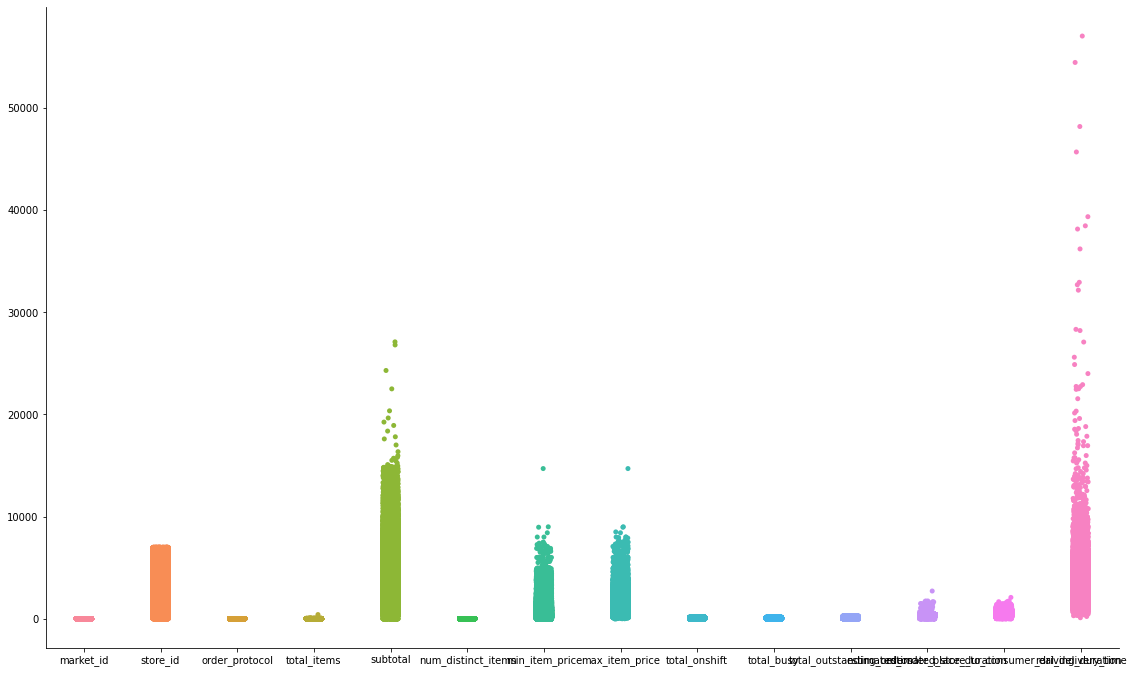

In [36]:
s = sns.catplot(data=delivery_df)
s.fig.set_size_inches(25,10)
plt.show()

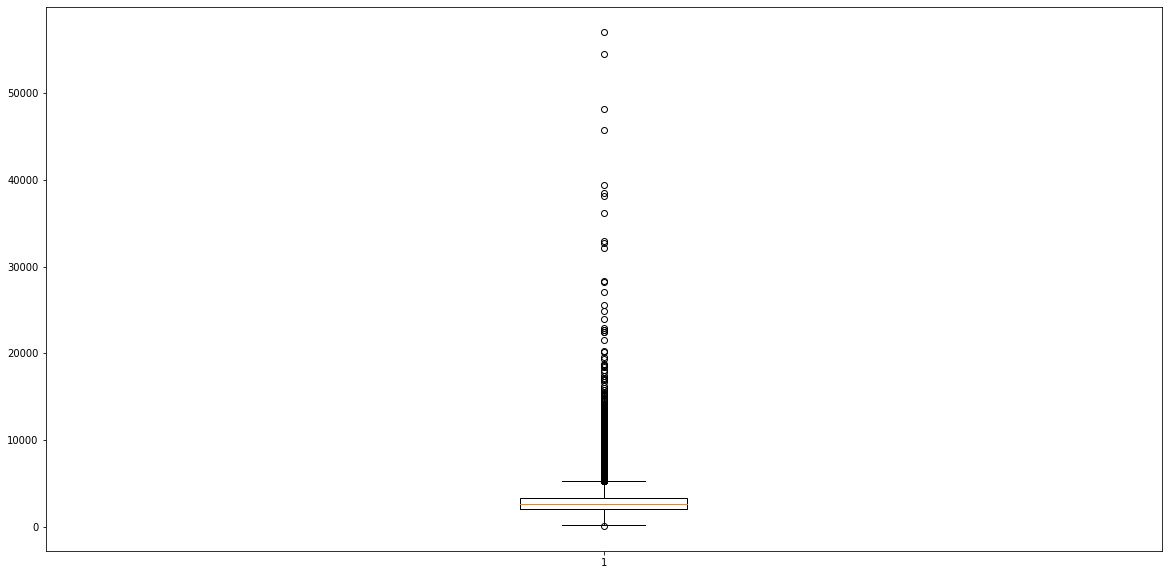

In [37]:
plt.figure(figsize=(20,10))
plt.boxplot(delivery_df['real_delivery_time'])
plt.show()

In [38]:
delivery_df['real_delivery_time'][delivery_df.real_delivery_time > 10000].count()

189

In [39]:
delivery_df.drop(delivery_df.loc[delivery_df.real_delivery_time > 10000].index, inplace=True)

In [40]:
delivery_df.isnull().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift                                   0
total_busy                                      0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
real_delivery_time                              0
dtype: int64

In [41]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(delivery_df['store_primary_category'])
delivery_df['store_primary_category'] = le.transform(delivery_df['store_primary_category'])

delivery_df.head()


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,real_delivery_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,47,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,51,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,51,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,51,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [42]:
import datetime as dt

delivery_df['created_at']=delivery_df['created_at'].map(dt.datetime.toordinal)
delivery_df['actual_delivery_time']=delivery_df['actual_delivery_time'].map(dt.datetime.toordinal)

delivery_df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,real_delivery_time
0,1.0,735635,735635,1845,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,735639,735639,5477,47,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,735620,735620,5477,51,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,735632,735632,5477,51,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,735644,735644,5477,51,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


# 학습/테스트 데이터 구분
위 데이터(delivery_raw.csv)에서 랜덤하게 10%를 추출해서 테스트 데이터로 사용하고 나머지는 학습데이터로 사용


In [43]:
delivery_df.shape

(196635, 17)

In [44]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(delivery_df, test_size=0.1)

In [45]:
train_dataset.shape

(176971, 17)

In [46]:
test_dataset.shape

(19664, 17)

In [47]:
y_train = pd.DataFrame(train_dataset.real_delivery_time)
X_train = train_dataset.drop('real_delivery_time', axis=1)
y_test = pd.DataFrame(test_dataset.real_delivery_time)
X_test = test_dataset.drop('real_delivery_time', axis=1)

In [48]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
model.coef_


array([[-2.47484780e+01, -2.04752514e+02,  2.06589763e+02,
        -5.17647982e-03,  3.38616857e-01,  9.16157999e+00,
         1.63943062e+00,  8.64633134e-02,  3.03726657e+01,
         1.06318406e-02,  5.98336319e-02, -2.19622823e+01,
        -7.33502606e+00,  2.11732043e+01,  1.34067946e+00,
         1.14646423e+00]])

In [49]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_train)
MSE = mean_squared_error(y_train, y_pred)
RMSE = np.sqrt(MSE)
RMSE



946.0533161489465

In [50]:
under_prediction = y_train.copy()
under_prediction['y_pred'] = y_pred
under = under_prediction['y_pred'][(under_prediction['real_delivery_time']>under_prediction['y_pred'])].count()
print(under)
print("under_prediction 비율 : ", under/X_train.shape[0])

73956
under_prediction 비율 :  0.4178989777986224


# 제출할 결과물
 - 간단한 요약문
 - 데이터 전처리와 속성 생성에 대한 간단한 설명
 - 학습을 위해서 어떤 모델을 사용했는지 그리고 어떠한 손실함수를 사용했는지를 간단히 설명
 - 테스트 데이터에 대한 평가지표들 (아래 두가지를 반드시 포함할 것)
    1. Root Mean Square Error (RMSE)
    2. Under-prediction의 비율 (under-prediction 개수 / 테스트 데이터의 샘플수)
 - 모델 학습에 사용한 Jupyter notebook 파일

In [51]:
y_test_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_test_pred)
RMSE = np.sqrt(MSE)
print("RMSE : ", RMSE)

RMSE :  946.6116290317036


In [52]:
under_prediction = y_test.copy()
under_prediction['y_pred'] = y_test_pred
under = under_prediction['y_pred'][(under_prediction['real_delivery_time']>under_prediction['y_pred'])].count()
print("under_prediction 수 : ",under)
print("under_prediction 비율 : ", under/X_test.shape[0])

under_prediction 수 :  8245
under_prediction 비율 :  0.41929414157851913
